In [2]:
import numpy as np
import faiss
import requests
from io import StringIO
import pandas as pd

# Dataset Initialization

In [50]:
res = requests.get('https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt')

text = res.text
text[:100]

'pair_ID\tsentence_A\tsentence_B\trelatedness_score\tentailment_judgment\n1\tA group of kids is playing in '

the sentences are seperated with \t

We need this in a dataframe, which we build from the `text` string like so:

In [51]:
data = pd.read_csv(StringIO(text), sep='\t')
data.head()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


We will take all samples from `sentence_A` and build sentence embeddings for each - which we can then store in FAISS.

In [52]:
sentences = data['sentence_A'].tolist()
sentences[:5]

['A group of kids is playing in a yard and an old man is standing in the background',
 'A group of children is playing in the house and there is no man standing in the background',
 'The young boys are playing outdoors and the man is smiling nearby',
 'The kids are playing outdoors near a man with a smile',
 'The young boys are playing outdoors and the man is smiling nearby']

And we will pull in the `sentence_B` column too, giving us ~4.5K *unique* sentences.

In [53]:
sentence_b = data['sentence_B'].tolist()
sentences.extend(sentence_b)
len(set(sentences))

4802

MORE DATA

This isn't a particularly large number, so let's pull in a few more similar datasets.

In [54]:
urls = [
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.train.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2013/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/images.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2015/images.test.tsv'
]

In [55]:
for url in urls:
    res = requests.get(url)
    # extract to dataframe
    data = pd.read_csv(StringIO(res.text), sep='\t', header=None, on_bad_lines='skip')
    # add to columns 1 and 2 to sentences list
    sentences.extend(data[1].tolist())
    sentences.extend(data[2].tolist())

In [56]:
len(set(sentences))

14505

Before converting to our sentence embeddings, we will save to text file as backup.

In [57]:
# remove duplicates and NaN
sentences = [
    sentence.replace('\n', '') for sentence in list(set(sentences)) if type(sentence) is str
    ]

In [58]:
with open('sentences.txt', 'w') as fp:
    fp.write('\n'.join(sentences))

Now we have 14.5K *unique* sentences, a much better size. We'll go ahead and build the sentence embeddings 

In [59]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')



We can save/load from file in the case of needing to reload the notebook for any reason later.

In [60]:
import numpy as np

embedding_files = [f"data/sentence_embeddings_15K/embeddings_{i}.npy" for i in range(57)]  

sentence_embeddings_list = [np.load(file) for file in embedding_files]

sentence_embeddings = np.concatenate(sentence_embeddings_list, axis=0)

sentence_embeddings.shape

(14504, 768)

In [61]:
sentence_embeddings.shape[0]

14504

In [62]:
# saving data
# split = 256
# file_count = 0
# for i in range(0, sentence_embeddings.shape[0], split):
#     end = i + split
#     if end > sentence_embeddings.shape[0] + 1:
#         end = sentence_embeddings.shape[0] + 1
#     file_count = '0' + str(file_count) if file_count < 0 else str(file_count)
#     with open(f'./sim_sentences/embeddings_{file_count}.npy', 'wb') as fp:
#         np.save(fp, sentence_embeddings[i:end, :])
#     print(f"embeddings_{file_count}.npy | {i} -> {end}")
#     file_count = int(file_count) + 1

We setup our FAISS database dimensionality (number of dimensions per vector) based on these vectors.

In [63]:
d = sentence_embeddings.shape[1]
d

768

# Flat L2 Index

We initialize the flat L2 distance index `IndexFlatL2`, all we need is the specify the vector dimensionality - which in this case is `d == 768` (to align with the sentence-BERT model output embeddings of size `768`).

**IndexFlatL2 measures the L2 (or Euclidean) distance between all given points between our query vector, and the vectors loaded into the index. It’s simple, very accurate, but not too fast.**

In [64]:
index = faiss.IndexFlatL2(d)

Often, we will use indexes that require us to `train` them on our data before being used (if we are grouping or transforming the data in any way). `IndexFlatL2` however, is a simple operation and only requires that we calculate distances between vectors when we introduce our query vector `xq` during search. So, in this case, no training is required - which we can confirm by checking the `is_trained` attribute.

In [65]:
index.is_trained

True

Okay so once we're happy that our index is prepared, we then add new vectors using the `add` method.

In [66]:
index.add(sentence_embeddings)

In [67]:
index.ntotal

14504

Then search given a query `xq` and number of nearest neigbors to return `k`.

In [104]:
QUERY = "pets are somwhere in the world"

In [105]:
k = 4
xq = model.encode([QUERY])

In [106]:
%%time
D, I = index.search(xq, k)  # search
# D - distances
# I - indices
# print(D)
print(I) 

[[12472 13065 12085 10674]]
CPU times: total: 0 ns
Wall time: 8.5 ms


In [107]:
with open('sentences.txt', 'r') as fp:
    sentences = fp.read().splitlines()

len(sentences)


14504

In [108]:
[f'{i}: {sentences[i]}' for i in I[0]]

['12472: cause to procreate (animals).',
 '13065: a public enclosure for stray or unlicensed dogs.',
 '12085: a public enclosure for animals, as dogs',
 '10674: A dog which is furry and black is in a backyard and is carrying a basket in its mouth.']

---

# Adding Partitioning to the Index

FAISS allows us to add an additional step to optimize our search efficiency using a variety of different methods. A popular approach is to partition the index into *Voronoi cells*. Using this method we would take our query vector `xq`, identify the *cell* it belongs to, and then use our `IndexFlatL2` to search between the query vector `xq` and all indexed vectors belonging to that *cell*. We can also include vectors from other nearby cells too.

We initialize our new partitioned index by first adding our previous `IndexFlatL2` operation as a quantization step (another step in the search process), and feeding this into the new `IndexIVFFlat` operation like so:

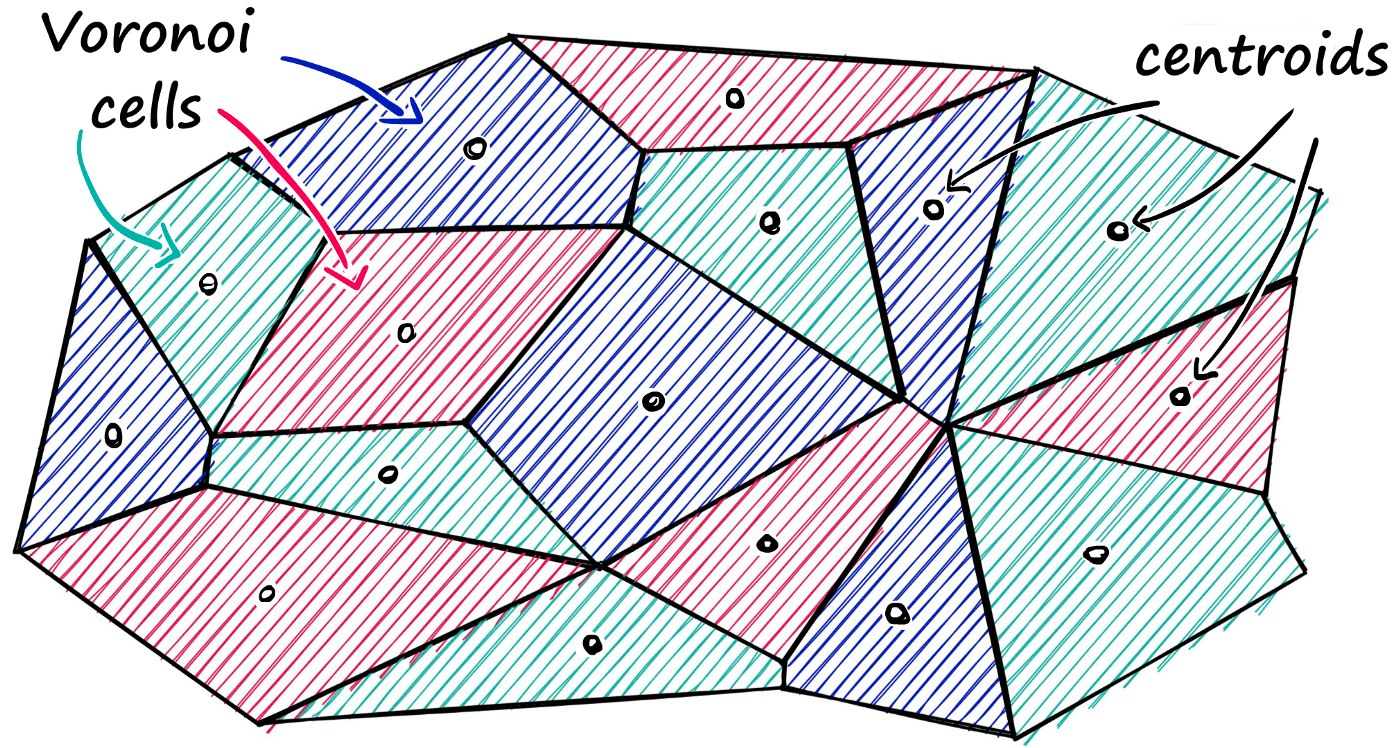

In [110]:
nlist = 50
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)

Here we've added a new parameter `nlist`. We use `nlist` to define how many partitions we'd like our index to have. 

When we built the previous, `IndexFlatL2`-only index, we noted that no training was required as no grouping/transformation was required to build that index. Now that we've added partitioning using `IndexIVFFlat`, this is no longer the case. Let's take a look at the `is_trained` attribute.

In [111]:
index.is_trained

False

So, what we need to do now is `train` our index on our data, which we do *before* adding any data to the index (otherwise the index cannot know how to group each vector).

In [112]:
index.train(sentence_embeddings)
index.is_trained

True

Now our index is trained, we add our data just as we did before.

In [113]:
index.add(sentence_embeddings)
index.ntotal

14504

Let's search again using the same indexed sentence embeddings and the same query `xq`.

In [114]:
%%time
D, I = index.search(xq, k)  # search
print(I)

[[   19  8892  1659 10724]]
CPU times: total: 0 ns
Wall time: 4.7 ms


In [115]:
[f'{i}: {sentences[i]}' for i in I[0]]

['19: live in the bushes as a fugitive or guerilla',
 '8892: A close up of an ostrich face.',
 '1659: A chimp is practicing martial arts',
 '10724: A lemur is hanging on a cord']

We can increase the number of nearby cells to search too with `nprobe`.

In [116]:
index.nprobe = 10

In [121]:
%%time
D, I = index.search(xq, k)  # search
print(I)

[[12472 13065 12085 10674]]
CPU times: total: 0 ns
Wall time: 5.07 ms


In [118]:
[f'{i}: {sentences[i]}' for i in I[0]]

['12472: cause to procreate (animals).',
 '13065: a public enclosure for stray or unlicensed dogs.',
 '12085: a public enclosure for animals, as dogs',
 '10674: A dog which is furry and black is in a backyard and is carrying a basket in its mouth.']

Increasing the number of `nprobe` will improve the accuracy of our search, but cost time. Our earlier `IndexFlatL2`-only search was *exhaustive* (it compared every single vector) and so it identified the closest matches with a perfect accuracy. 

It's worth noting that the time taken can change with each run too, if we rerun the above block, we usually get a different time:

In [123]:
%%time
D, I = index.search(xq, k)
print(I)

[[12472 13065 12085 10674]]
CPU times: total: 0 ns
Wall time: 5.65 ms


With `make_direct_map`:

In [124]:
index.make_direct_map()

In [125]:
index.reconstruct(7460)[:100]

array([-0.44000912,  0.33769077, -0.30594158,  0.21360019, -0.33061752,
       -0.0022613 , -0.4396163 ,  0.21904255, -0.3140246 ,  0.9906835 ,
        0.4143855 ,  1.0589153 ,  0.2015624 , -0.07848668,  0.18000662,
        0.25210422, -1.3608178 , -0.51935464, -0.09201971,  0.63870543,
       -1.0023916 ,  0.4925477 ,  0.43913165, -0.52203333, -0.01606323,
        0.5916573 , -0.4378051 ,  1.0052072 , -1.311943  , -0.63891697,
       -0.9231751 ,  0.60150903,  0.11641748, -0.16370611,  0.5344435 ,
       -1.0791782 ,  0.6740778 ,  0.32491085,  0.2224865 , -0.27228832,
       -0.3545608 , -0.00383685,  0.33400893,  0.5899536 , -0.65313864,
        0.1638189 ,  0.06604495,  1.2896262 ,  0.7661708 , -0.46596   ,
        0.28142768, -0.767334  ,  0.799837  ,  1.3655713 ,  0.04080359,
        0.5571153 ,  0.08656055, -1.1104416 , -0.06244938,  0.03832094,
       -0.4932782 , -0.5936905 ,  0.00273059, -0.20183043, -0.43994737,
        0.24577314, -0.09227153, -0.44267213, -1.3618326 ,  0.19

We've now significantly reduced the search time, what can we do next?

# Quantization

Well, when storing these vectors we're storing the full (eg `Flat`) vector. Now in very big datasets this can quickly become a problem. Typically, we look at big datasets, and when working with large dataset we will find that storing the full vectors consumes too much space.

Fortunately, FAISS comes with the ability to *compress* our vectors using transformations based on *Product Quantization* (PQ). 

PQ achieves this approximated distance operation by compressing the vectors themselves. This consists of a few steps.

1. We split the every original vector into several subvectors.

2. For each set of subvectors, we perform a clustering operation, creating many centroids for each subvector set.

3. In our vector of subvectors, we replace each subvector with the ID of it's nearest centroid.

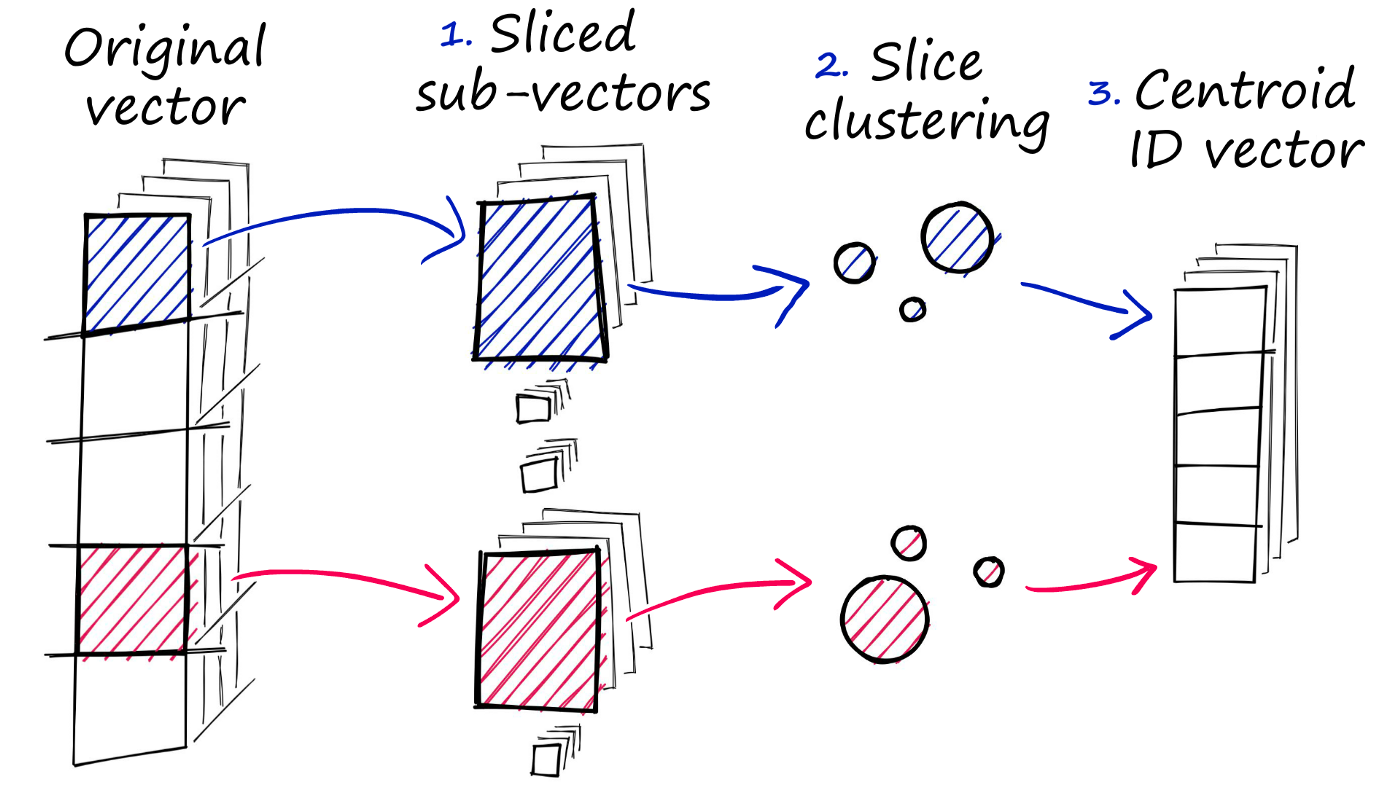

In [126]:
m = 8  # number of centroid IDs in final compressed vectors
bits = 8 # number of bits in each centroid

quantizer = faiss.IndexFlatL2(d)  # we keep the same L2 distance flat index
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits) 

Again, we'll need to `train` the index.

In [127]:
index.is_trained

False

In [128]:
index.train(sentence_embeddings)

And `add` our vectors.

In [129]:
index.add(sentence_embeddings)

Let's compare it to our previous index *without* PQ, and an `nprobe` value of `10`.

In [130]:
index.nprobe = 10

In [132]:
%%time
D, I = index.search(xq, k)
print(I)

[[12472 12780  4618 13877]]
CPU times: total: 0 ns
Wall time: 2.82 ms


FROM 5.65ms TO 2.82ms!

In [133]:
[f'{i}: {sentences[i]}' for i in I[0]]

['12472: cause to procreate (animals).',
 '12780: An animal is crawling under a piece of furniture',
 '4618: A dog rolls on the ground.',
 '13877: A dog is rolling from side to side']

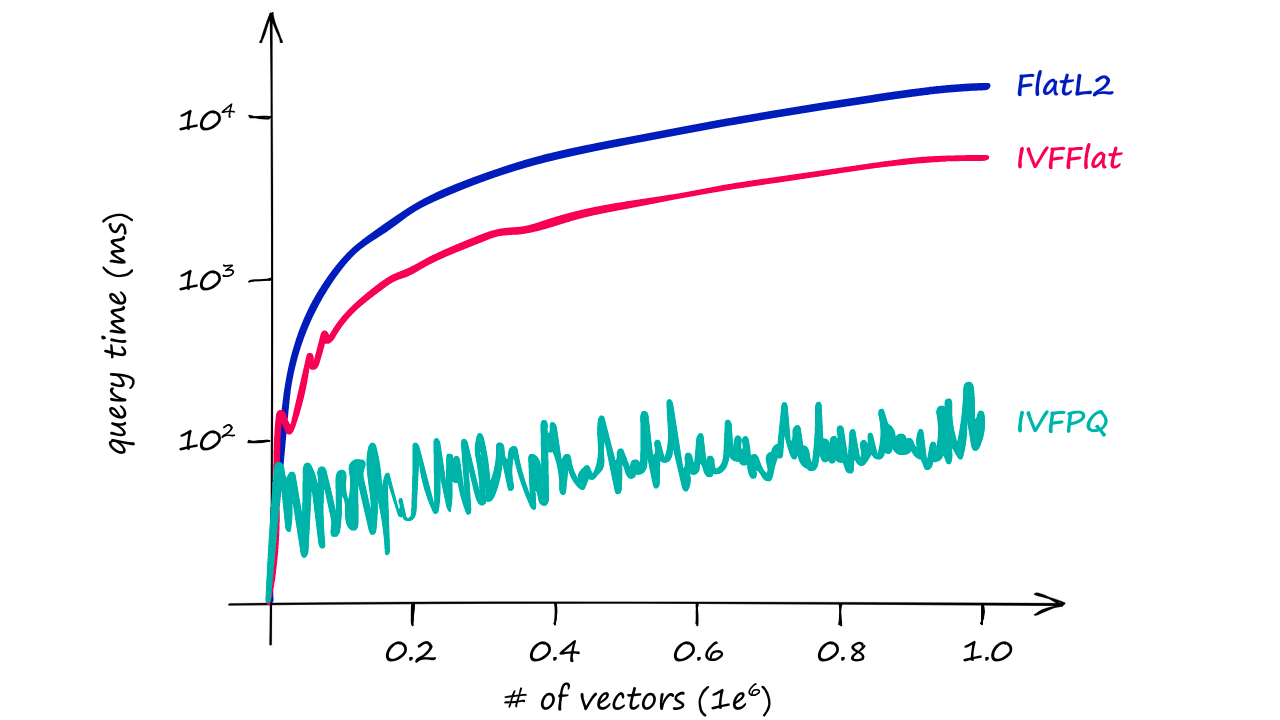

thanks to James Briggs